A common use case in probabilistic programming is that we want to infer the
likelihood that a certain random variable will take a specific value. Pyro lets
us do this easily for any site.

In [43]:
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import torch

from pyro import poutine

Suppose we want to weigh objects with a faulty
scale that has some measurement noise. This follows a simple Gaussian model:

$$ measurement | weight \sim \mathcal{N}(weight, 0.75) $$

In [44]:

def make_dist(weight, noise):
    return dist.Normal(weight, noise)

weight, noise = 8, 0.75
scale_dist = make_dist(weight, noise)
measurement_1 = pyro.sample("measurement_1", scale_dist)
prob = scale_dist.log_prob(measurement_1).exp()
print(f"measurement: {measurement_1};\t probability: {prob}")


measurement: 8.308494567871094;	 probability: 0.48877593874931335


Here we took an object with a true weight of 8 and got some noisy measurement.
We then evaluated the probability of observing that measurement. We can easily
use this functionality to plot the PDF of our faulty scale and the object.

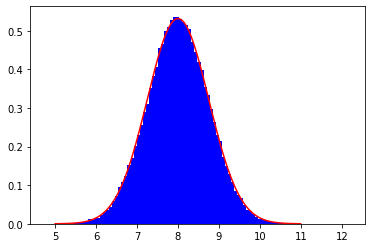

In [45]:
lb = weight - noise * 4
ub = weight + noise * 4
resolution = 1000
measurements = torch.arange(lb, ub, (ub - lb) / resolution)
probs = scale_dist.log_prob(measurements).exp()
plt.plot(measurements, probs, color="red")
ones = torch.ones(100000)
multiscale_dist = make_dist(weight * ones, noise * ones)
samples = pyro.sample("sample", multiscale_dist)
plt.hist(samples.cpu().numpy(), bins=100, density=True, color="blue")
plt.show()

The PDF looks like a Gaussian centered at $x=8$, and lines up closely with the
sample histogram. Now let's examine a more complicated model, where we have a
good guess of the object's weight. Mathematically, this becomes

$$ weight | guess \sim \mathcal{N}(guess, 1) $$

$$ measurement | weight \sim \mathcal{N}(weight, 0.75) $$



In [46]:
def model_1(guess):
   weight = pyro.sample("weight", dist.Normal(guess, 1.0))
   y = pyro.sample("measurement", dist.Normal(weight, 0.75))
   return y

The `trace` class lets us maintain a trace of the entire model, so we can query
the particular terms we care about without having to pass them around between
different name space.

In [47]:
guess = torch.tensor(7.5)
trace_1 = poutine.trace(model_1).get_trace(guess)
trace_1.compute_log_prob()
nodes =  trace_1.nodes
print(f"weight: {nodes['weight']['value']},"
      f" probability {nodes['weight']['log_prob'].exp()}")
print(f"measurement: {nodes['measurement']['value']},"
      f" probability {nodes['measurement']['log_prob'].exp()}")

weight: 8.166380882263184, probability 0.3195088803768158
measurement: 8.15375804901123, probability 0.5318477153778076


We can also condition the model to enforce that certain RVs will always have a
specific value. This is done with the `condition` API.

In [48]:
cond_model = pyro.condition(model_1,
                            data={"measurement": torch.tensor(9.5)})
cond_trace = poutine.trace(cond_model).get_trace(guess)
cond_trace.compute_log_prob()
nodes = cond_trace.nodes
print(f"weight: {nodes['weight']['value']},"
      f" probability {nodes['weight']['log_prob'].exp()}")
print(f"measurement: {nodes['measurement']['value']},"
      f" probability {nodes['measurement']['log_prob'].exp()}")

weight: 7.18613862991333, probability 0.3797686696052551
measurement: 9.5, probability 0.004560481756925583


We conditioned the `measurement` RV to evaluate to `9.5` so it was not sampled
from its respective distribution. Note, however, that this does not affect the
probability of the observation. The probability returned by pyro is
$p(measurement = 9.5 | \mathcal{N}(weight, 0.75)$, and not `1`, even though
there was a `100%` chance of `measurement` evaluating to `9.5`. Similarly, if
remove the conditioning on `measurement`, we see that the likelihood of `weight`
does not change, even though $p(weight | measurement) \neq p(weight)$.


In [49]:
cond_model = pyro.condition(model_1,
                            data={"weight": nodes["weight"]["value"]})
trace = poutine.trace(cond_model).get_trace(guess)
trace.compute_log_prob()
weight_node = trace.nodes["weight"]
print(weight_node["value"], weight_node["log_prob"].exp())

measurement_node = trace.nodes["measurement"]
print(measurement_node["value"], measurement_node["log_prob"].exp())


tensor(7.1861) tensor(0.3798)
tensor(7.1700) tensor(0.5318)


It's important to remember that the `condition` function does not actually
change the underlying distribution of the RV. Think of it as saying "let's
pretend that we happend to sample `X` for this variable". Hence, RVs upstream
of the conditioned variable do not change their likelihood.